In [476]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn

In [477]:

df = pd.read_csv('amazon_data_cleaned_01.csv')
df.columns

df.drop('Unnamed: 0', axis=1,inplace=True)
df = df.replace('nan', np.nan, regex=True)
df.drop(df[df.name==0].index, axis=0,inplace=True)
#drop duplicated values
df = df.drop_duplicates(['mat_url'])
duplicates = df.duplicated(['mat_url','name'])
print(duplicates.sum(), df.shape)
df[duplicates][['mat_url','combined_price', 'name']]


0 (1082, 16)


,mat_url,combined_price,name


In [478]:

print(df.shape)
df[duplicates][['mat_url','combined_price', 'name']]

(1082, 16)


,mat_url,combined_price,name


In [479]:
#Cleaning number of reviews

df = df.replace(np.nan, 0, regex=True)
pd.set_option('display.max_colwidth', 30)
df['number_reviews'] = df['number_reviews'].str.replace('ratings','')
df['number_reviews'] = df['number_reviews'].str.replace('Nan','0')
df['number_reviews'] = df['number_reviews'].str.replace(',','')
df['number_reviews'] = df['number_reviews'].str.replace('rating','').astype('int')


In [480]:
#cleaning rating out of 5
df['rating'] = df['rating'].str.replace('out of 5','').astype('float')

In [481]:
#cleaning weight and its dimentions ['pounds', nan, 'ounces', 'grams', 'kilograms']
#divide weight into float and dimention
df = df.replace(0,np.nan, regex=True)
df['weight_float'] = df['weight'].apply(lambda x:  x if type(x)==float else x.split()[0]).astype(float)
df['weight_dimention'] = df['weight'].apply(lambda x:  x if type(x)==float else x.split()[1]).str.lower()

In [482]:
class dimention_convertion_weight():
    '''
     pounds' 'ounces', 'grams' to 'kilograms'
    '''
    def __init__(self,value_float, dimention) :
        self.value = value_float
        self.dimention = dimention
        
    def convert (self):
        if self.dimention ==  'pounds':
            self.from_pound_to_kg() 
            return self.value
        elif self.dimention ==  'ounces':
            self.from_ounces_kg()
            return self.value
        elif self.dimention == 'grams':
            self.from_grams_to_kg()
            return self.value
        elif self.dimention == 'kilograms':
            return self.value

    def from_pound_to_kg( self):
       
           self.value =  self.value / 2.20462
       
    def from_ounces_kg(self):
       
            self.value =  self.value / 35.247
        
    def from_grams_to_kg(self):
        
           self.value =  self.value / 1000

Apply convertion_dimention_weight class, 24 mats have less than 0.3kg

In [483]:
df['weight_kg'] = df.apply(lambda row: dimention_convertion_weight(row.weight_float ,row.weight_dimention).convert(), axis=1)

weight_less_than =df['weight_kg'] [df['weight_kg'] < 0.5]
b = weight_less_than > 0
print(b.sum())
weight_less_than.unique()


41


array([0.45359291, 0.11339823, 0.26      , 0.002     , 0.08164672,
       0.34045451, 0.15875752, 0.0905    , 0.10432637, 0.29937132,
       0.2494761 , 0.49      , 0.18015718, 0.18143716, 0.34019468,
       0.18      , 0.27215575, 0.06241666, 0.4       , 0.18157574,
       0.3       , 0.2       , 0.00907186, 0.40823362, 0.00453593,
       0.28087497])

In [484]:
pd.set_option('display.max_colwidth', None)
#df[df['weight_kg'] < 0.5][b][['mat_url','weight_kg','weight_float','weight_dimention']]
#delete 697 and all where L is below 30 inches and W below 10

In [485]:
df.drop(['weight_float','weight_dimention','weight','table_features_color_care_material'], axis=1, inplace=True)

In [486]:
df.shape

(1082, 15)

Converting dimentions and thickness in three rows: L X W X thickness_two

In [487]:
#L
df['dimentions'] = df['dimentions'].str.strip().str.lower()
df['L'] = df['dimentions'].apply(lambda x:  x if type(x)==float else x.split('x',1)[0]).astype(float)


In [488]:
#W
df['W'] = df['dimentions'].apply(lambda x:  x if type(x)==float else x.split('x',1)[1]).str.strip()
df['W'] = df['W'].apply(lambda x:  x if type(x)==float else x.split(' ',1)[0]).astype(float)


In [489]:
#thickness
#filter from W forward
df['thickness_2'] = df['dimentions'].apply(lambda x:  x if type(x)==float else x.split('x',1)[1]).str.strip()
#filter from thickness forward
df['thickness_2'] = df['thickness_2'].apply(lambda x:  x if type(x)==float else x.split(' ',1)[1]).str.strip()
#filter only thickness
regex_thickness = re.compile(r'[\d+\.]+[\d*]')
df['thickness_2']= df['thickness_2'].apply(lambda x:  x if type(x)==float else re.findall(regex_thickness,x))
df['thickness_2'] = df['thickness_2'].apply(lambda y: np.nan  if y==[] else float(str(y).replace("['",'').replace("']",'')))
df['thickness_2'][df['thickness_2'].notnull()]
#dimention
#filter only text
regex_dimention = re.compile(r'[a-z]+')
df['dimention_LXW']= df['dimentions'].apply(lambda x:  x if type(x)==float else re.findall(regex_dimention,x))
df['dimention_LXW'] = df['dimention_LXW'].apply(lambda y: np.nan  if y==[]  else str(y))
df['dimention_LXW'].unique()
#all is in inches / but is mm for the thickness

array(["['x', 'inches']", 'nan', "['x', 'x', 'inchesitem']",
       "['x', 'x', 'inches']", "['x', 'inchesitem']"], dtype=object)

In [490]:
#df.isna().sum()

In [491]:
#put max value as L and min value as thickness
df = df.replace(np.nan, 0, regex=True)
df['L'] = df[['W','L','thickness_2']].max(axis=1)
df['thickness_2'] = df[['W','L','thickness_2']].min(axis=1)
df['A'] = df[['W','thickness_2']].max(axis=1)
df['B'] = df[['W','L']].min(axis=1)
df['W'] = df[['A','B']].max(axis=1)


Half of  dimensions are nan and 1/5 of exixsting ones are not valid

In [492]:
df = df.replace(0,np.nan, regex=True)
L_less_than_20 = df[df['L'] < 20][['weight_kg','L','W','thickness_2']]
W_less_than_20 = df[df['W'] < 10][['weight_kg','L','W','thickness_2']]
W_less_than_20.shape 

(114, 4)

In [493]:
df['thickness']=df['thickness'].str.strip()
df['thickness_float'] = df['thickness'].apply(lambda x:  x if type(x)==float else x.split()[0]).astype(float)
df['thickness_dim']= df['thickness'].apply(lambda x:  x if type(x)==float else x.split()[1]).str.lower().str.replace('item','').str.replace('league','')
print(df['thickness_dim'].unique())

['micron' nan 'millimeters' 'inches' 'centimeters' 'mils' 'feet']


In [494]:
class dimention_convertion_thickness():
    '''
     'feet', 'micron' 'centimeters', 'inches' to 'milimeters'
    '''
    def __init__(self,value_float, dimention) :
        self.value = value_float
        self.dimention = dimention
        
    def convert (self):
        if self.dimention == 'feet':
            self.from_feet_to_mm() 
            return self.value
        elif self.dimention ==  'micron':
             self.from_micron_to_mm()
             return self.value
        elif self.dimention == 'centimeters':
            self.from_cm_to_mm()
            return self.value
        elif self.dimention == 'inches':
            self.from_inches_to_mm()
            return self.value
        elif self.dimention == 'millimeters':
            return self.value
        elif self.dimention == 'mils':
            return self.value  
        elif self.value == 'nan':
            return np.nan   
        else:
            return(np.nan)  

    def from_feet_to_mm( self):
       
           self.value =  self.value * 304.8
       
    def from_micron_to_mm(self):
       
             self.value =  self.value / 1000
        
    def from_cm_to_mm(self):
        
           self.value =  self.value * 10

    def from_inches_to_mm(self):
        
           self.value =  self.value * 25.4


          
#thickness from second source is in differnt dimentions will convert all to mm in column thickness_mm
#apply convertion_dimention class
df['thickness_mm'] = df.apply(lambda row: dimention_convertion_thickness(row.thickness_float ,row.thickness_dim).convert(), axis=1)
df['thickness_mm'].unique()

array([6.0000e-03,        nan, 6.0000e+00, 1.0000e+01, 6.3500e+00,
       4.5000e+00, 7.6200e+00, 8.0000e+00, 5.0000e+00, 2.0000e+00,
       7.0000e+00, 3.3020e+00, 6.0960e+00, 1.5240e+02, 1.2700e+01,
       5.0800e+00, 3.5560e+00, 4.7000e+00, 4.0000e+00, 1.5000e+00,
       1.5000e+01, 7.8740e+00, 1.5748e+01, 2.5400e+01, 3.0000e+00,
       1.0000e+00, 9.6520e+00, 4.0640e+00, 5.5000e+00, 6.0000e+01,
       5.5880e+00, 4.3180e+00, 1.5240e+00, 7.3152e+01, 1.3000e+00,
       2.0320e+00, 5.0800e+01, 9.9060e+00, 2.8956e+01, 4.3000e+00])

In [495]:
df.drop(['thickness','thickness_float','thickness_dim'], axis=1, inplace=True)

(4, 30)

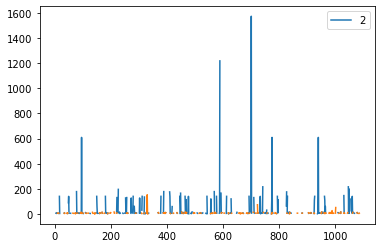

In [496]:
#thickness_2 from inches to mm
df['thickness_2'] =df['thickness_2'].apply(lambda x: dimention_convertion_thickness(x ,'inches').convert())
#%%
#comparing  thickness_2 from table features and thickness_mm
plt.plot(df['thickness_2'], label ='2')
plt.plot(df['thickness_mm'])
plt.legend()
mask_1 = df['thickness_2'] > 0
mask_2 = df['thickness_mm'] > 0
mask_3 = df['thickness_2'] > 15 
mask_4 = df['thickness_mm'] > 15
len(df['thickness_mm'][mask_1][mask_2][mask_4]), len(df['thickness_2'][mask_1][mask_2][mask_3])
# about 3 mats has a width higher than 20mm (14, 29)

In [497]:
mask_1 = df['thickness_2'] > 0
mask_2 = df['thickness_mm'] > 0
mask_3 = df['thickness_2'] < 3 
mask_4 = df['thickness_mm'] < 3
len(df['thickness_mm'][mask_1][mask_2][mask_4]), len(df['thickness_2'][mask_1][mask_2][mask_3])
# about 10  mats have a width less than 3mm (14, 29)

(15, 10)

Comparing thickness from the two sources and 262 out of 265 have less thann 2mm difference: 

In [498]:

#%%
thickness_1 = df['thickness_mm'][mask_1][mask_2]
thickness_2 = df['thickness_2'][mask_1][mask_2]
mask_for_difference_less_than_2mm = (thickness_1-thickness_2) < 2
mask_for_difference_more_than_2mm = (thickness_1-thickness_2) > 2
#%%
data = [
    ['difference less than 2',mask_for_difference_less_than_2mm.sum()],
    ['difference more than 2',mask_for_difference_more_than_2mm.sum()],
    ['len thickness_2', len(thickness_2)],
    ['len thickness_1',len(thickness_1)],
    ['len data', len(df['thickness_mm'])],
    ['nulls thickness 1',df['thickness_mm'].isna().sum()],
    ['nulls thickness 2',df['thickness_2'].isna().sum()]
]
df_data = pd.DataFrame(data, columns = ['Name', 'Value'])
df_data
#thickness_2 and thickness_mm are the 265 



,Name,Value
0,difference less than 2,261
1,difference more than 2,3
2,len thickness_2,264
3,len thickness_1,264
4,len data,1082
5,nulls thickness 1,699
6,nulls thickness 2,609


Combining thickness from different sources in one column 

In [499]:
df = df.replace(np.nan,0, regex=True)
df['final_thickness'] = df['thickness_mm']
print(df['final_thickness'].isna().sum())
#df['final_thickness'] = df['final_thickness'].apply(lambda x:400 if x==0 else x )
df['final_thickness'] = df.apply(lambda row: row.thickness_2 if row.thickness_mm==0 else row.thickness_mm, axis=1)
df = df.replace(0,np.nan ,regex=True)
print(df['final_thickness'].isnull().sum())

#df['final_thickness'].unique()

0
490


Dropping rows with the wrong thickness

In [500]:
df = df.drop(df[df.final_thickness < 3].index)
df = df.drop(df[df.final_thickness >20].index)
df.dropna().shape, df.shape

((62, 22), (973, 22))

In [501]:

df.drop(['A','B','dimention_LXW','thickness_2','name','thickness_mm'], axis=1, inplace=True)
df.isna().sum()

mat_url              1
number_reviews      82
rating              83
reviews_text        28
other_prices         0
other_colors         0
combined_price     182
dimentions         492
care               587
material           275
brand              172
color              165
weight_kg          581
L                  492
W                  492
final_thickness    490
dtype: int64

In [502]:
df.columns

Index(['mat_url', 'number_reviews', 'rating', 'reviews_text', 'other_prices',
       'other_colors', 'combined_price', 'dimentions', 'care', 'material',
       'brand', 'color', 'weight_kg', 'L', 'W', 'final_thickness'],
      dtype='object')

In [503]:
df['material'].unique()

array([nan, ' Thermoplastic Elastomer', ' FoamProduct ',
       ' Nitrile Butadiene Rubber', ' Plastic',
       ' TPE Double LayerProduct ', ' Natural Rubber and SuedeProduct ',
       ' Polyvinyl Chloride FoamProduct ', ' TpeProduct ',
       ' RubberProduct ', ' Tpe', ' Thermoplastic ElastomersProduct ',
       ' Nitrile Butadiene Rubber FoamProduct ', ' PlasticItem ', ' Cork',
       ' TPE', ' Aluminum', ' Foam', ' Composite', ' 麂皮Product ',
       ' Thermoplastic Elastomers', ' CorkProduct ',
       ' Polyvinyl ChlorideProduct ', ' Suede',
       ' Durable Eco-friendly TPEProduct ',
       ' Oak tree bark & natural rubberProduct ',
       ' Polyvinyl ChlorideItem ', ' OtherProduct ',
       ' Nitrile Butadiene Rubber Foam', ' PVCProduct ',
       ' Thermoplastic ElastomersItem ', ' PlasticProduct ',
       ' SuedeProduct ', ' PolyesterProduct ', ' TPEProduct ', ' Rubber',
       ' CottonItem ', ' JuteProduct ', ' Abs',
       ' Eco Friendly Cork and Natural RubberProduct ', ' TPERP

In [504]:
df = df.replace(np.nan,'nan', regex=True)
df[df.material == 'nan'].index

Int64Index([   1,    3,    9,   13,   17,   23,   25,   27,   30,   31,
            ...
            1058, 1063, 1067, 1070, 1071, 1072, 1075, 1076, 1082, 1085],
           dtype='int64', length=275)

In [521]:
to_remove =['metal','aluminum','gurus earth mat','fabricbrand genericshape rectangular']
df = df.drop(df[df.material == np.nan].index)
for i in to_remove:
    df.drop(df[df.material == i].index, inplace=True)
df['material'] = df['material'].str.replace('Product','').str.replace('Item', '').str.replace('麂皮','polyester').str.strip().str.lower()
df['material'] = df['material'].str.replace('thermoplastic elastomers','tpe').str.replace('聚氯乙烯','pvc')
df['material'] = df['material'].str.replace('thermoplastic elastomer','tpe')
df['material'] = df['material'].str.replace('plastic','tpe')
df['material'] = df['material'].str.replace('other','nan')
df['material'] = df['material'].str.replace('天然橡胶','natural rubber').str.replace('橡胶','rubber')
df['material'] = df['material'].str.replace('polyvinyl chloride','pvc')
df['material'] = df['material'].str.replace('vinyl, memory foam, pvc','pvc')
df['material'] = df['material'].str.replace('vinyl','pvc')
df['material'] = df['material'].str.replace('nitrile butadiene rubber','nbr')
df['material'] = df['material'].str.replace('nitrile, nbr','nbr')
df['material'] = df['material'].str.replace('polyester, tpe','polyester')
df['material'] = df['material'].str.replace('fitness exercise mat','nan')
df['material'] = df['material'].str.replace('nbr imported from germany','nbr')
df['material'] = df['material'].str.replace('nbr foam','nbr') 
df['material'] = df['material'].str.replace('pvc foam','pvc')
df['material'] = df['material'].str.replace('foam, nbr','nbr')                                                   
df['material'] = df['material'].str.replace('tpe, rubber','tpe')                                                                  
df['material'] = df['material'].str.replace('rubber, polyester','rubber')                                                            
df['material'] = df['material'].str.replace('tpe, rubber','tpe')  
df['material'] = df['material'].str.replace('kapok','wood')                                                               
df['material'] = df['material'].str.replace('recycled wetsuits','neoprene') 
df['material'] = df['material'].str.replace('polyurethane'  ,'pu')  
df['material'] = df['material'].str.replace('hemp'  ,'cotton')  
df['material'] = df['material'].str.replace('abs'  ,'tpe')   
df['material'] = df['material'].str.replace('xpe'  ,'foam') 
df['material'] = df['material'].str.replace('poe'  ,'tpe')                               
df['material'] = df['material'].str.replace('eva'  ,'tpe')
df['material'] = df['material'].str.replace('blend'  ,'tpe')
df['material'] = df['material'].str.replace('resin'  ,'tpe')
df['material'] = df['material'].str.replace('flannel'  ,'cotton') 
df['material'] = df['material'].str.replace('microfiber'  ,'neoprene') 
#r'flannel',r'resin',r'eva',r'blend',r'composite'

for i in [r"microfiber",r"suede",r"cotton",r"cork",r"rubber",r"polyester",r"neoprene", r"pvc", r'pu',r'jute', r"foam",r"per",r"tpe"]:
            df['material'] [df['material'].str.contains(i)] = i

#pd.options.display.max_rows = 4000
#pd.set_option('display.max_colwidth', None)

print(df['material'].value_counts())



tpe          321
nbr           49
rubber        45
pvc           40
foam          25
cork          24
polyester     12
cotton        12
per           10
suede          9
pu             6
jute           5
neoprene       5
Name: material, dtype: int64


<ipython-input-521-641bfb534995>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['material'] [df['material'].str.contains(i)] = i


In [522]:
for i in ['composite']:
    print(df[df.material==i]['combined_price'])


Series([], Name: combined_price, dtype: float64)


Materials:

-Jute is a long, soft, shiny bast fiber that can be spun into coarse, strong threads

-tpe : termoplastic elastomer

-Polyolefin elastomers (POE) are elastomers based on a polyethylene backbone

-Polyurethane (often abbreviated PUR and PU) is a polymer composed of organic units joined by carbamate (urethane) links

-Polyurethane , Polyurethane is pu

-EVA stands for Ethylene-Vinyl Acetate. That is an elastomeric polymer that produces materials which are "rubber-like" in softness and flexibility. It is a plastic made by combining ethylene and vinyl acetate to create rubber like properties which can be used for shoe soles

-Flannel is a soft woven fabric, of various fineness. Flannel was originally made from carded wool or worsted yarn, but is now often made from either wool, cotton, or synthetic fiber.

In [523]:
df = df.replace(np.nan,0, regex=True)
df = df.replace('nan',0, regex=True)
df = df.drop(df[df.material == 0].index)
df = df.drop(df[df.combined_price == 0].index)
df.material = df.material.astype("category")
df.shape

(563, 16)

Model 'rating','number_reviews' and 'combined_price' as target

In [524]:
df_rating_reviews = df[['rating','number_reviews','combined_price']]
print( df_rating_reviews.dropna().shape , df_rating_reviews.shape)

(563, 3) (563, 3)


In [525]:
df_rating_reviews = df_rating_reviews.dropna()
df_rating_reviews.isna().sum()


rating            0
number_reviews    0
combined_price    0
dtype: int64

In [526]:
df_rating_reviews.describe()

,rating,number_reviews,combined_price
count,563.000000,563.000000,563.000000
mean,4.288632,711.293073,33.212647
std,1.125115,1828.634081,20.760307
min,0.000000,0.000000,6.490000
25%,4.500000,13.000000,22.990000
50%,4.600000,74.000000,27.990000
75%,4.700000,308.000000,36.525000
max,5.000000,22045.000000,287.860000


In [527]:
from sklearn import datasets, model_selection
# 15% for validation and test, 70% for train in total
y = df_rating_reviews['combined_price']
X =df_rating_reviews[['rating','number_reviews']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3)

X_validation, X_test, y_validation, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.5
)

print(X_train.shape, y_train.shape)

(394, 2) (394,)


In [528]:
from sklearn import linear_model
model = linear_model.LinearRegression(normalize=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(y_pred[:5], "\n", y_train[:5])


[16.74446759 32.33651921 32.16033219 31.10871323 32.35634669] 
 108    21.16
67     18.99
78     25.99
618    26.97
974    35.99
Name: combined_price, dtype: float64


In [529]:
from sklearn import metrics

metrics.mean_squared_error(y_train, y_pred)

278.92365305970003

Model with material added 

In [530]:
df_rating_reviews_material = df[['rating','number_reviews','material','combined_price']]
df_rating_reviews_material.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563 entries, 2 to 1083
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   rating          563 non-null    float64 
 1   number_reviews  563 non-null    float64 
 2   material        563 non-null    category
 3   combined_price  563 non-null    float64 
dtypes: category(1), float64(3)
memory usage: 35.0 KB


In [531]:
df_rating_reviews_material = df_rating_reviews_material.dropna()

In [532]:
dummies = pd.get_dummies(df_rating_reviews_material['material'], prefix='material')
df_rating_reviews_material = pd.concat((df_rating_reviews_material, dummies), axis=1).drop('material', axis=1)
print(df_rating_reviews_material.shape)
df_rating_reviews_material.columns

(563, 16)


Index(['rating', 'number_reviews', 'combined_price', 'material_cork',
       'material_cotton', 'material_foam', 'material_jute', 'material_nbr',
       'material_neoprene', 'material_per', 'material_polyester',
       'material_pu', 'material_pvc', 'material_rubber', 'material_suede',
       'material_tpe'],
      dtype='object')

In [544]:
y = df_rating_reviews_material['combined_price']
X =df_rating_reviews_material[['rating', 'number_reviews', 'material_cork',
       'material_cotton', 'material_foam', 'material_jute', 'material_nbr',
       'material_neoprene', 'material_per', 'material_polyester',
       'material_pu', 'material_pvc', 'material_rubber', 'material_suede',
       'material_tpe']]
X.shape


(563, 15)

In [545]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3, stratify= X[['material_cork',
       'material_cotton', 'material_foam', 'material_jute', 'material_nbr',
       'material_neoprene', 'material_per', 'material_polyester',
       'material_pu', 'material_pvc', 'material_rubber', 'material_suede',
       'material_tpe']])

X_validation, X_test, y_validation, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.5
)
X_train.shape

(394, 15)

In [546]:
model = linear_model.LinearRegression(normalize=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(y_pred[:5], "\n", y[:5])


[22.10494625 29.65239288 20.19829069 29.8135602  29.03155769] 
 2     19.99
5     15.99
7     24.99
8     23.99
10    32.99
Name: combined_price, dtype: float64


In [547]:
y_val_pred = model.predict(X_validation)
metrics.mean_squared_error(y_train, y_pred), metrics.mean_squared_error(y_validation, y_val_pred)
sklearn.metrics.r2_score(y_train, y_pred), sklearn.metrics.r2_score(y_validation, y_val_pred)

(0.24141817327220194, 0.20881927477248374)

Apply one-hot encoding to material

In [433]:
'''

Completed:
    'number_reviews', 'rating','combined_price', 'weight',dimentions',  'thickness', 'material'

To explore NLP:
    'reviews_text', 

To complete in branch other_prices_color
     'other_prices', other_colors'
 '
Still to complete in master and applying hot encoder:
    'care',  'brand', 'color'
    similar percentage of each class in validation and test
    bins for width an input 5mm for np.nan values
'''


"\n\nCompleted:\n    'number_reviews', 'rating','combined_price', 'weight',dimentions',  'thickness', 'material'\n\nTo explore NLP:\n    'reviews_text', \n\nTo complete in branch other_prices_color\n     'other_prices', other_colors'\n '\nStill to complete in master and applying hot encoder:\n    'care',  'brand', 'color'\n    similar percentage of each class in validation and test\n    bins for width an input 5mm for np.nan values\n"